# Lending Tree Loan Status: Upsampling
## Classification: XGBoost GPU
### Hyperopt HPO

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install eli5
import os
import random
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold 
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.0 MB/s 
     |████████████████████████████████| 133 kB 64.7 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=dca80aeeedd0833328030b037363111f5b4c86688841facd1329266ddf3af2fa
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


Wed Oct 12 05:22:34 2022       
+-----------------------------------------------

In [ ]:
# Set seed 
seed_value = 42
os.environ['xgb_GPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = pd.read_csv('trainDF_US.csv', low_memory=False)
testDF = pd.read_csv('testDF_US.csv', low_memory=False)

In [ ]:
# Set up train/test split
X_train = trainDF.drop('loan_status', axis=1)
y_train = trainDF.loan_status
X_test = testDF.drop('loan_status', axis=1)
y_test = testDF.loan_status

## 100 Trials npAverage 5-fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=5, shuffle=True, random_state=seed_value)

# Define parameter grid
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    
    """Objective function to tune a `XGBoostClassifier` model."""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        tree_method='gpu_hist',
                        scale_pos_weight=1,
                        use_label_encoder=False,
                        random_state=seed_value,
                        verbosity=0,
                        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train, 
                              scoring='roc_auc', cv=kfolds)
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.average(scores)
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])
    
    return {'loss': loss, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_Upsampling_100_GPU_npAverage.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-10 02:56:45.716100
100%|██████████| 100/100 [5:21:03<00:00, 192.64s/it, best loss: 1.939165692593106]
Start Time           2022-02-10 02:56:45.716100
End Time             2022-02-10 08:17:49.452302
5:21:03


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.939165692593106, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 180.73087198699977, 'status': 'ok'}, {'loss': 1.9594784211577976, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 206, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 155.96057789800034, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_100_GPU_npAverage.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value,
                                            verbosity=0,
                                            **best_bayes_params)
# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_Upsampling_100_GPU_npAverage.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_Upsampling_100_GPU_npAverage.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Upsampling 100trials GPU npAverage')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Xgboost HPO Upsampling 100trials GPU npAverage
Results from Xgboost HPO 100 GPU npAverage on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    377848
           1       0.58      0.84      0.69     54625

    accuracy                           0.90    432473
   macro avg       0.78      0.87      0.81    432473
weighted avg       0.92      0.90      0.91    432473



Confusion matrix:
[[344984  32864]
 [  8986  45639]]


Accuracy score : 0.903
Precision score : 0.581
Recall score : 0.835
F1 score : 0.686


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 100 GP0 npAverage trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                               preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 100 GP0 npAverage trials optimization scores 0.94153 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_100_GPU_npAverage.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

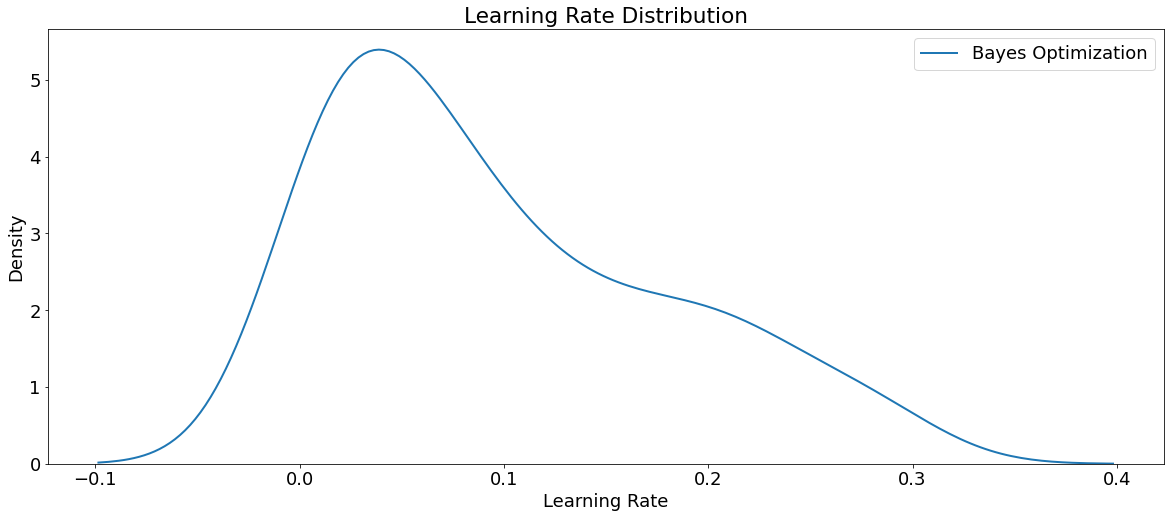

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

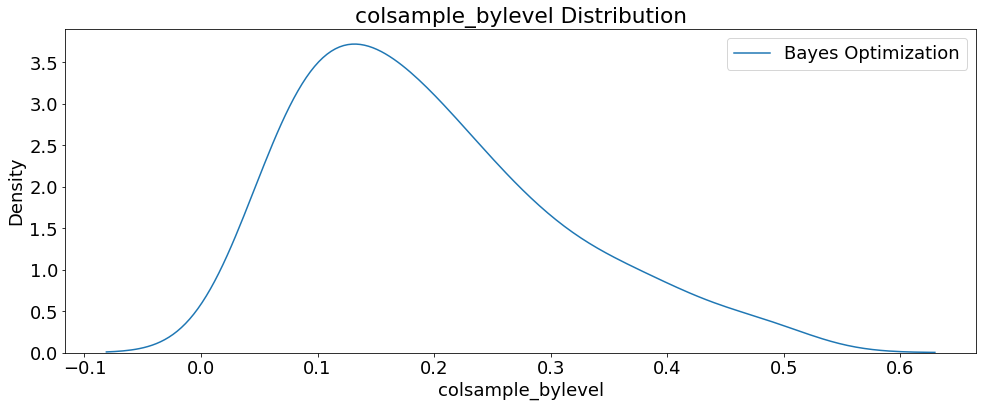

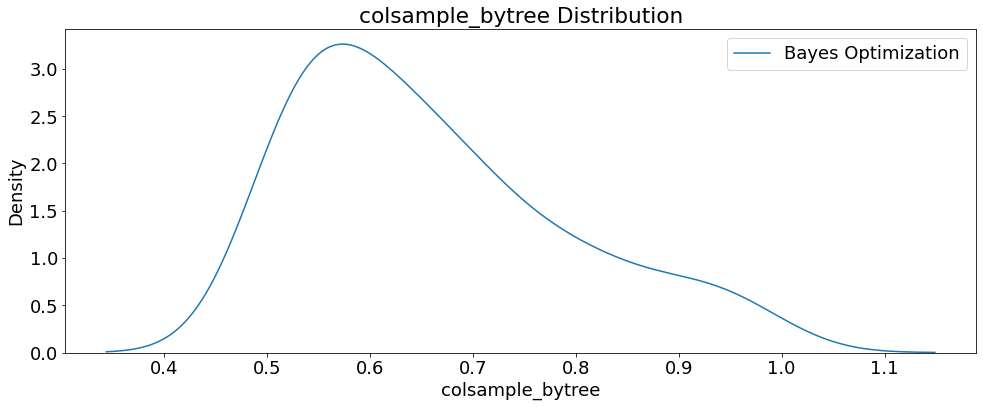

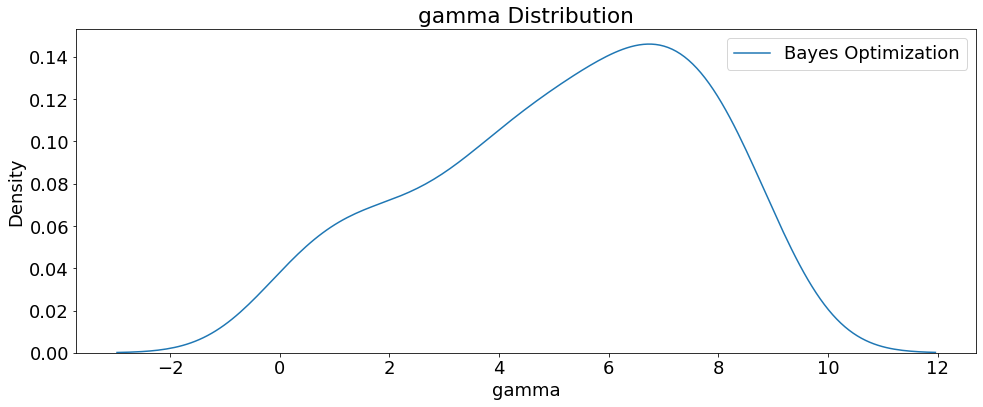

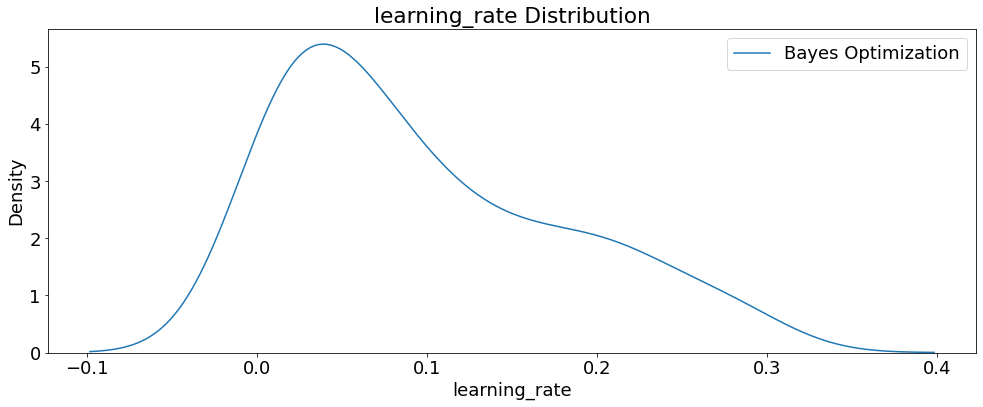

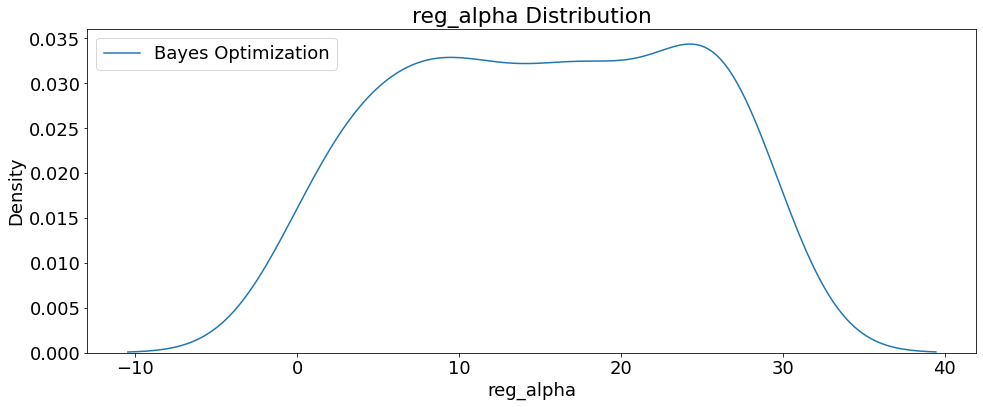

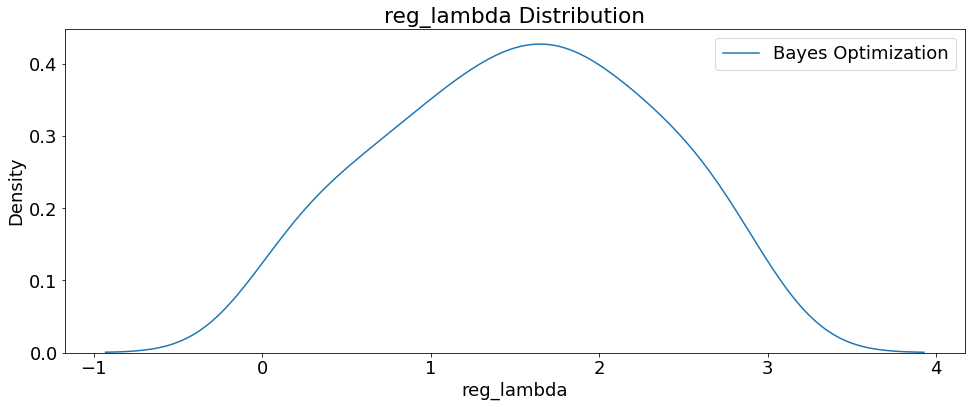

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

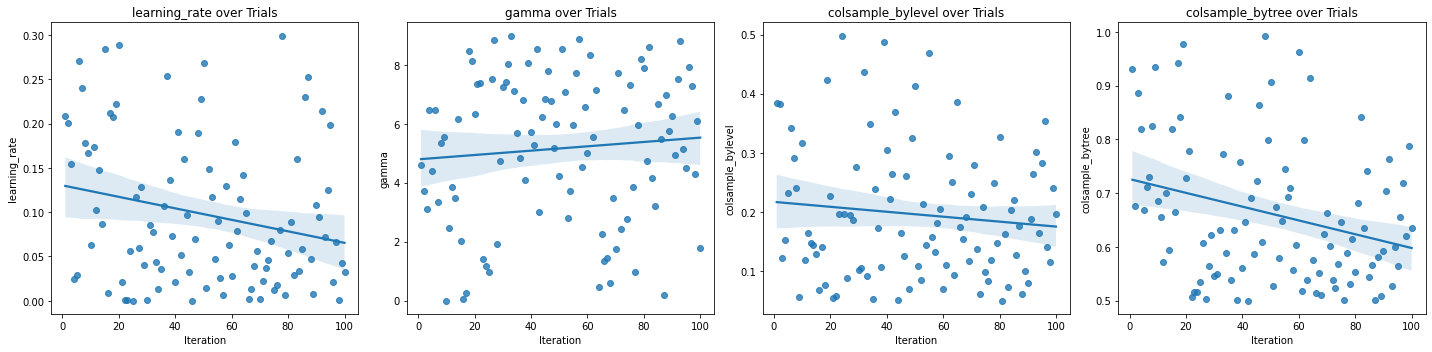

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

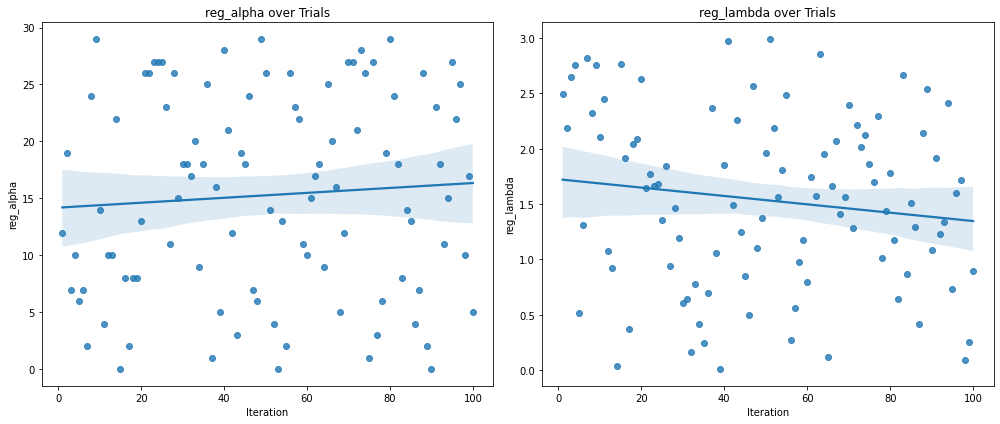

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_npAverage_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_npAverage_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0731 ± 0.0005,last_pymnt_amnt
0.0701 ± 0.0006,out_prncp
0.0501 ± 0.0004,recoveries
0.0065 ± 0.0002,total_pymnt
0.0021 ± 0.0001,loan_amnt
0.0013 ± 0.0001,total_rec_late_fee
0.0011 ± 0.0001,installment
0.0007 ± 0.0002,num_bc_tl
0.0003 ± 0.0001,application_type_Joint App
0.0002 ± 0.0001,delinq_2yrs


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance, 
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_100_GPU_npAverage_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,last_pymnt_amnt,0.073134,0.000261
1,out_prncp,0.070059,0.000300
2,recoveries,0.050104,0.000184
3,total_pymnt,0.006501,0.000104
4,loan_amnt,0.002132,0.000069
5,total_rec_late_fee,0.001299,0.000047
6,installment,0.001053,0.000073
7,num_bc_tl,0.000723,0.000082
8,application_type_Joint App,0.000298,0.000042
9,delinq_2yrs,0.000198,0.000056


## 100 Trials npAverage 10-fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value) 

# File to save first results
out_file = 'XGB_HPO_Upsampling_100_GPU_npAverage_10fold.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-10 13:26:59.286260
100%|██████████| 100/100 [12:03:21<00:00, 434.01s/it, best loss: 1.934879637251848]
Start Time           2022-02-10 13:26:59.286260
End Time             2022-02-11 01:30:20.798982
12:03:21


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.934879637251848, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 415.13588985299975, 'status': 'ok'}, {'loss': 1.959176053107075, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 206, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 352.4840246219992, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_100_GPU_npAverage_10fold.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value,
                                            verbosity=0,
                                            **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_Upsampling_100_GPU_npAverage_10fold.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_Upsampling_100_GPU_npAverage_10fold.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Upsampling 100trials GPU npAverage')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Xgboost HPO Upsampling 100trials GPU npAverage
Results from Xgboost HPO 100 GPU npAverage on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    377848
           1       0.58      0.84      0.69     54625

    accuracy                           0.90    432473
   macro avg       0.78      0.87      0.81    432473
weighted avg       0.92      0.90      0.91    432473



Confusion matrix:
[[344984  32864]
 [  8986  45639]]


Accuracy score : 0.903
Precision score : 0.581
Recall score : 0.835
F1 score : 0.686


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 100 GP0 npAverage 10 fold trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                                       preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 100 GP0 npAverage 10 fold trials optimization scores 0.94153 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_100_GPU_npAverage_10fold.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

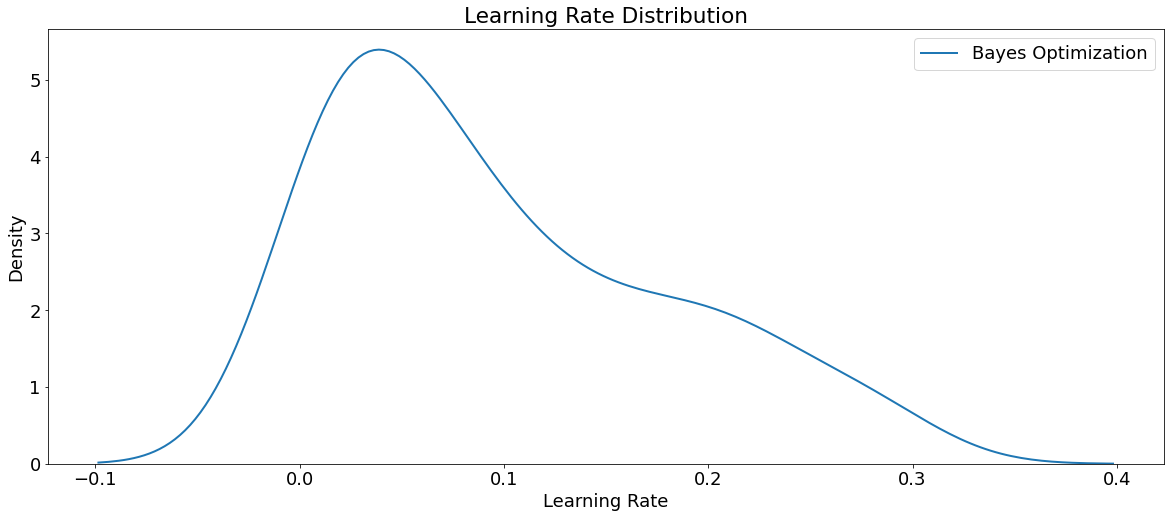

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

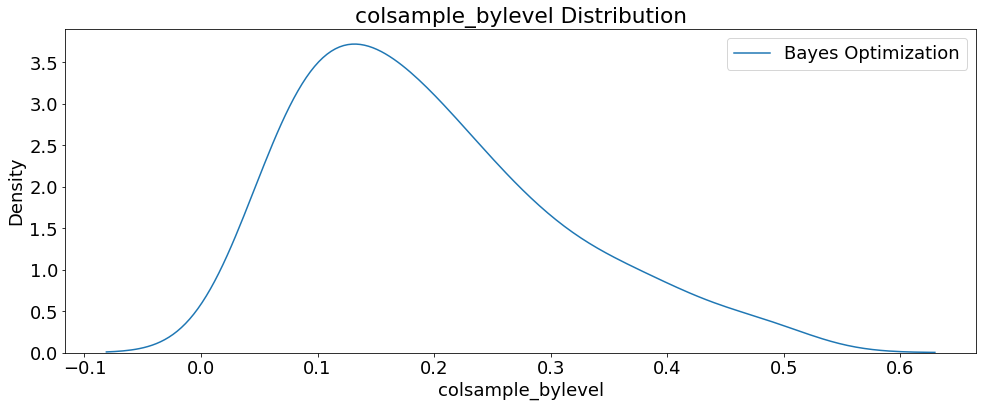

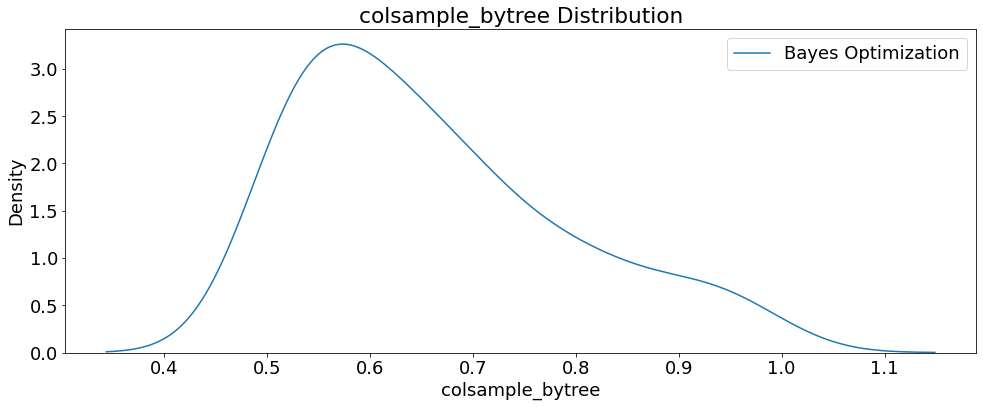

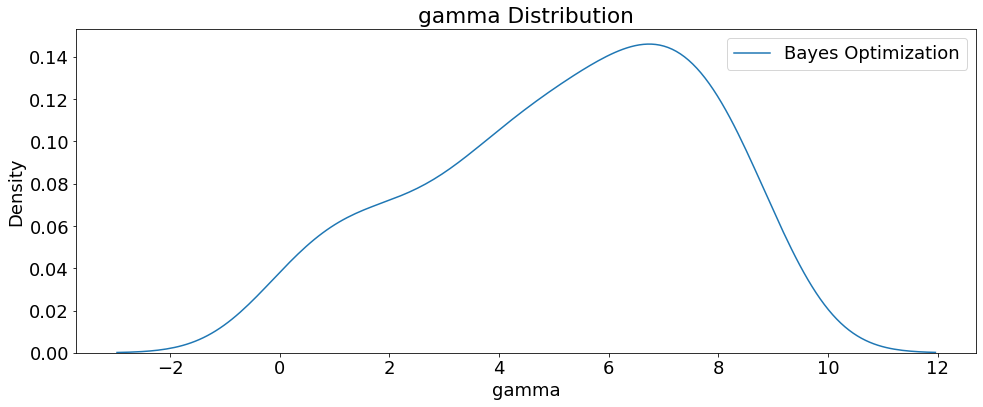

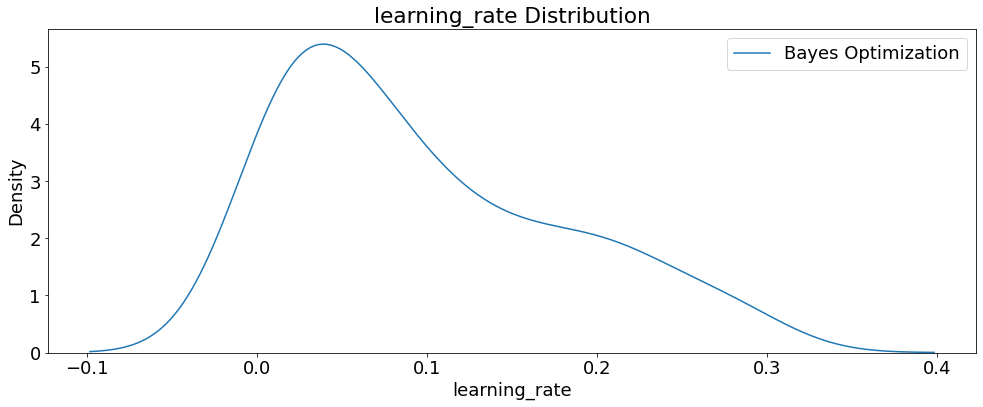

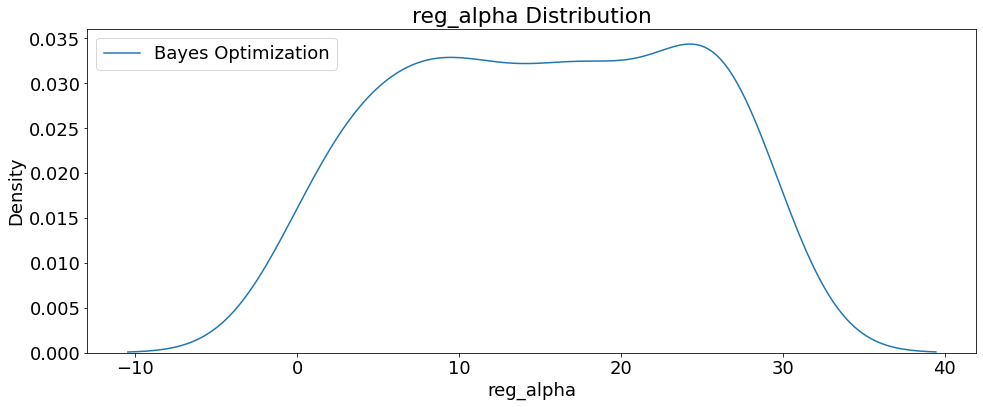

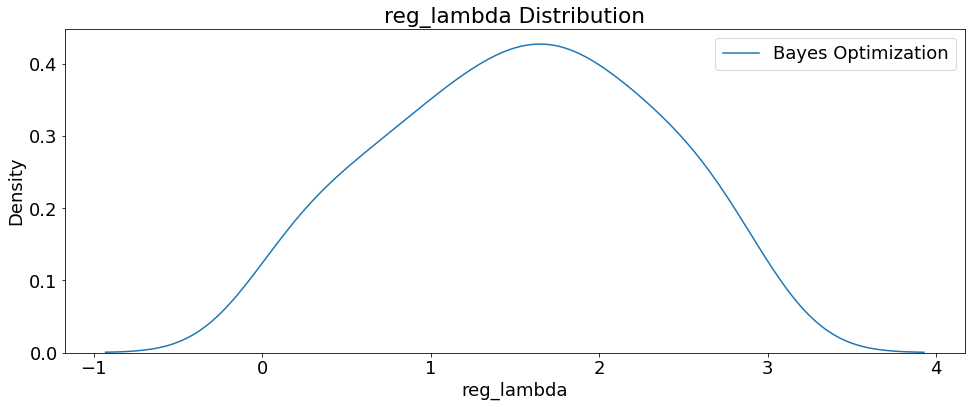

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

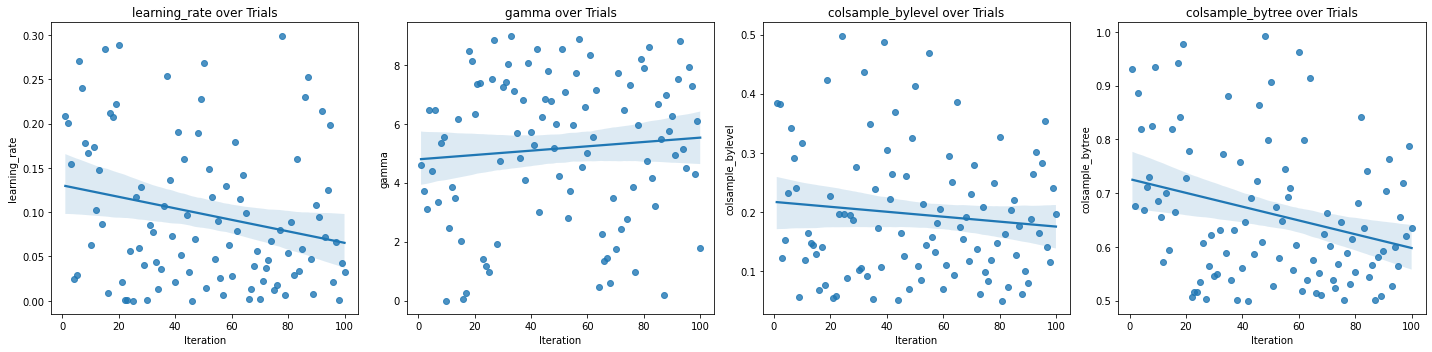

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

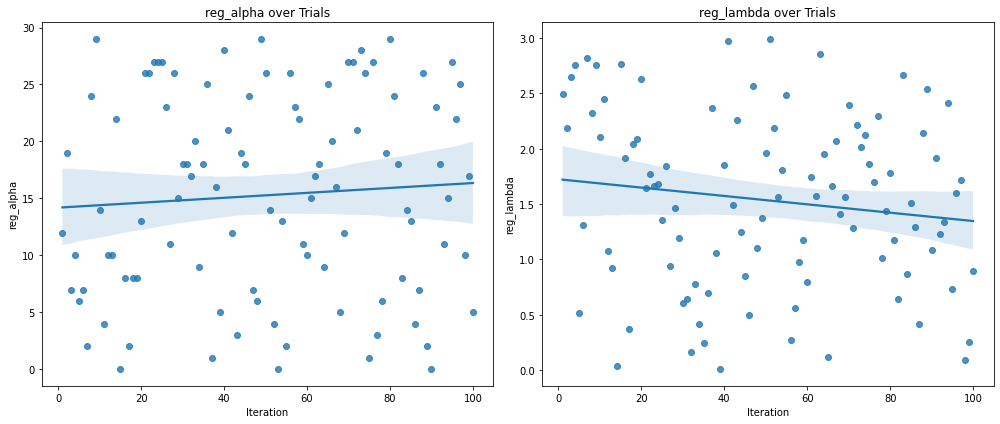

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/ML/Xgboost/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_npAverage_10fold_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_npAverage_10fold_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0731 ± 0.0005,last_pymnt_amnt
0.0701 ± 0.0006,out_prncp
0.0501 ± 0.0004,recoveries
0.0065 ± 0.0002,total_pymnt
0.0021 ± 0.0001,loan_amnt
0.0013 ± 0.0001,total_rec_late_fee
0.0011 ± 0.0001,installment
0.0007 ± 0.0002,num_bc_tl
0.0003 ± 0.0001,application_type_Joint App
0.0002 ± 0.0001,delinq_2yrs


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_100_GPU_npAverage_10fold_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,last_pymnt_amnt,0.073134,0.000261
1,out_prncp,0.070059,0.000300
2,recoveries,0.050104,0.000184
3,total_pymnt,0.006501,0.000104
4,loan_amnt,0.002132,0.000069
5,total_rec_late_fee,0.001299,0.000047
6,installment,0.001053,0.000073
7,num_bc_tl,0.000723,0.000082
8,application_type_Joint App,0.000298,0.000042
9,delinq_2yrs,0.000198,0.000056


## 100 Trials 3-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# Define a function for optimization of hyperparameters
def xgb_hpo(config): 
    
    """Objective function to tune a `XGBoostClassifier` model."""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        tree_method='gpu_hist',
                        scale_pos_weight=1,
                        use_label_encoder=False,
                        random_state=seed_value,
                        verbosity=0,
                        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train, 
                              scoring='roc_auc', cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    best_score = np.max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])
    
    return {'loss': loss, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# File to save first results
out_file = 'XGB_HPO_Upsampling_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-05 01:13:15.708885
100%|██████████| 100/100 [2:38:12<00:00, 94.93s/it, best loss: 1.9272027323257785]
Start Time           2022-02-05 01:13:15.708885
End Time             2022-02-05 03:51:28.514443
2:38:12


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 100 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9272027323257785, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 89.3074479830002, 'status': 'ok'}, {'loss': 1.9587423412669058, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 206, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 76.84754560199963, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value,
                                            verbosity=0,
                                            **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_Upsampling_HPO_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_Upsampling_HPO_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Upsampling 100trials GPU')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for XGBoost HPO Upsampling 100trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    377848
           1       0.58      0.84      0.69     54625

    accuracy                           0.90    432473
   macro avg       0.78      0.87      0.81    432473
weighted avg       0.92      0.90      0.91    432473



Confusion matrix:
[[344992  32856]
 [  8985  45640]]


Accuracy score : 0.903
Precision score : 0.581
Recall score : 0.836
F1 score : 0.686


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 100 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                     preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 100 GPU trials optimization scores 0.94153 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_100_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

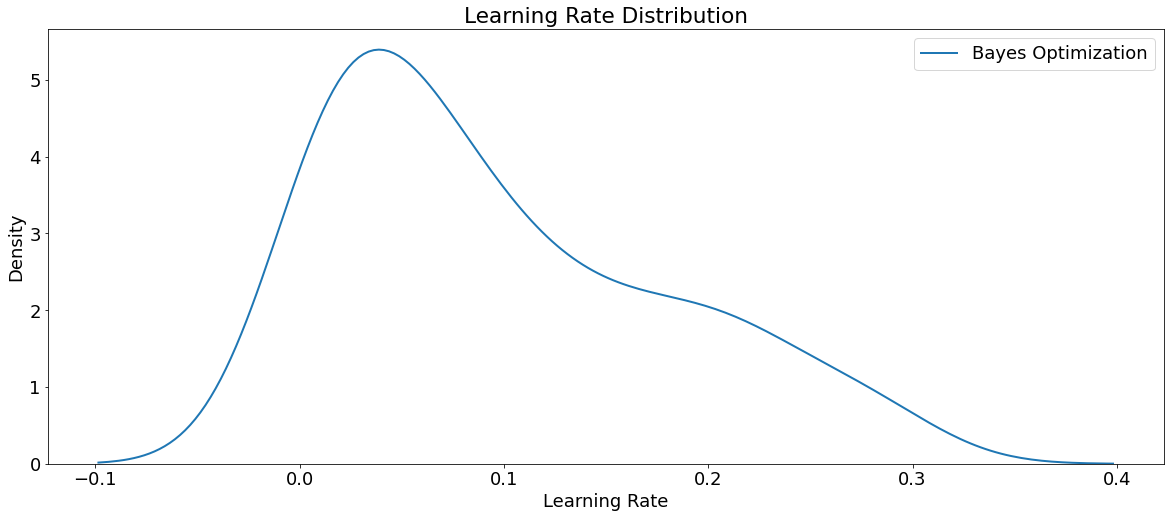

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

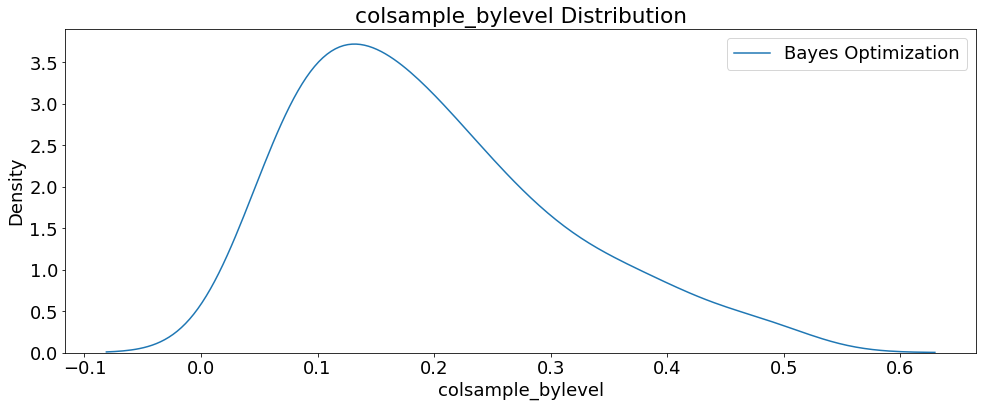

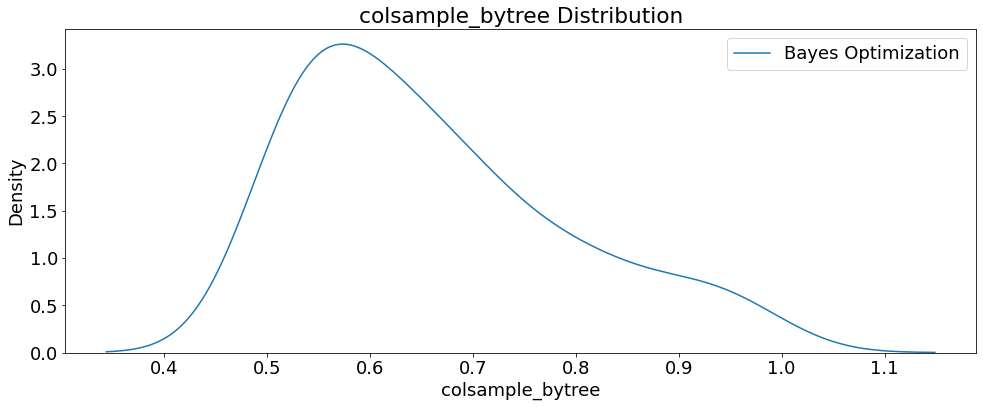

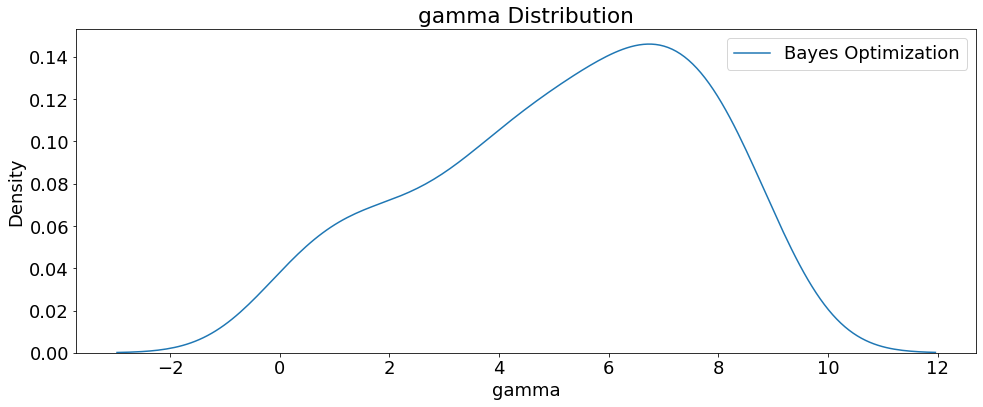

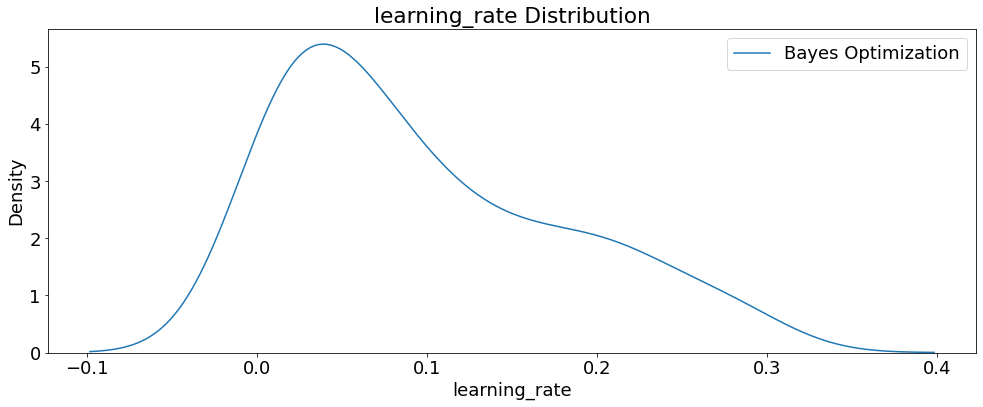

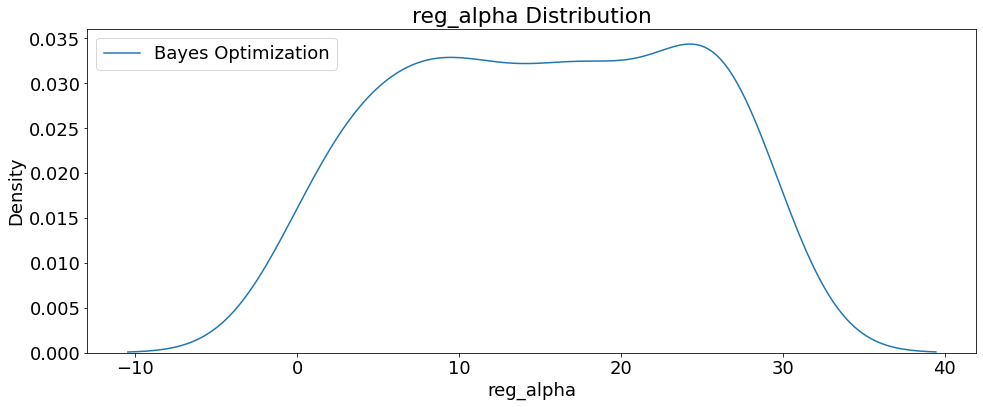

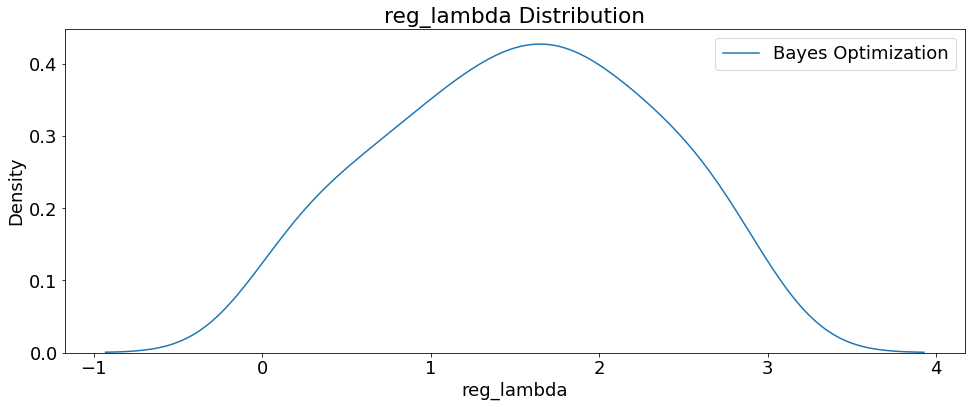

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

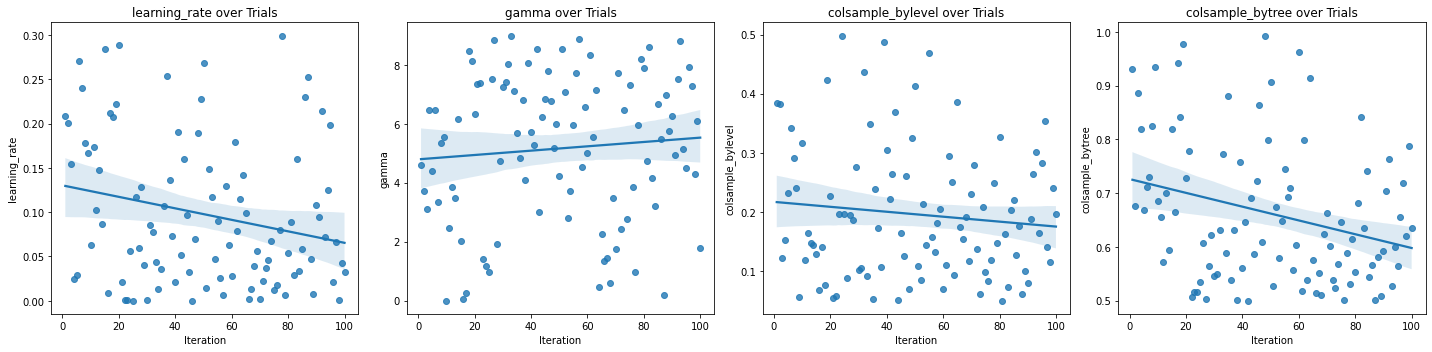

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

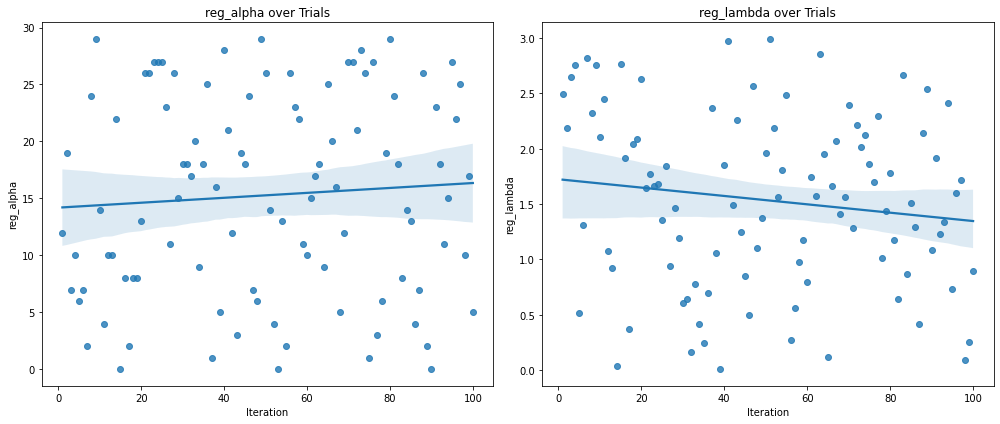

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0731 ± 0.0005,last_pymnt_amnt
0.0701 ± 0.0006,out_prncp
0.0501 ± 0.0004,recoveries
0.0065 ± 0.0002,total_pymnt
0.0021 ± 0.0001,loan_amnt
0.0013 ± 0.0001,total_rec_late_fee
0.0011 ± 0.0001,installment
0.0007 ± 0.0002,num_bc_tl
0.0003 ± 0.0001,application_type_Joint App
0.0002 ± 0.0001,delinq_2yrs


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance, 
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_100_GPU_WeightsExplain.csv', 
           index=False)
exp

,feature,weight,std
0,last_pymnt_amnt,0.073134,0.000261
1,out_prncp,0.070059,0.000300
2,recoveries,0.050104,0.000184
3,total_pymnt,0.006501,0.000104
4,loan_amnt,0.002132,0.000069
5,total_rec_late_fee,0.001299,0.000047
6,installment,0.001053,0.000073
7,num_bc_tl,0.000723,0.000082
8,application_type_Joint App,0.000298,0.000042
9,delinq_2yrs,0.000198,0.000056


## 100 Trials 5-fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Set same k-folds for reproducibility
kfolds = KFold(n_splits=5, shuffle=True, random_state=seed_value)

# File to save first results
out_file = 'XGB_HPO_Upsampling_100_GPU_5fold.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-11 20:47:38.509531
100%|██████████| 100/100 [5:24:55<00:00, 194.95s/it, best loss: 1.9343710108182373]
Start Time           2022-02-11 20:47:38.509531
End Time             2022-02-12 02:12:33.686933
5:24:55


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 100 trials 5fold: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 100 trials 5fold: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9343710108182373, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 181.94988403800016, 'status': 'ok'}, {'loss': 1.9587176334655172, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 206, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 157.47054124900023, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_100_GPU_5fold.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value,
                                            verbosity=0,
                                            **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_Upsampling_100_GPU_5fold.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_Upsampling_100_GPU_5fold.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Upsampling 100trials GPU 5fold')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Xgboost HPO Upsampling 100trials GPU 5fold
Results from Xgboost HPO 100 GPU 5fold on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    377848
           1       0.58      0.84      0.69     54625

    accuracy                           0.90    432473
   macro avg       0.78      0.87      0.81    432473
weighted avg       0.92      0.90      0.91    432473



Confusion matrix:
[[344984  32864]
 [  8986  45639]]


Accuracy score : 0.903
Precision score : 0.581
Recall score : 0.835
F1 score : 0.686


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]

print('The best model from Upsampling Bayes 100 GPU 5fold trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                           preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 100 GPU 5fold trials optimization scores 0.94153 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_100_GPU_5fold.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

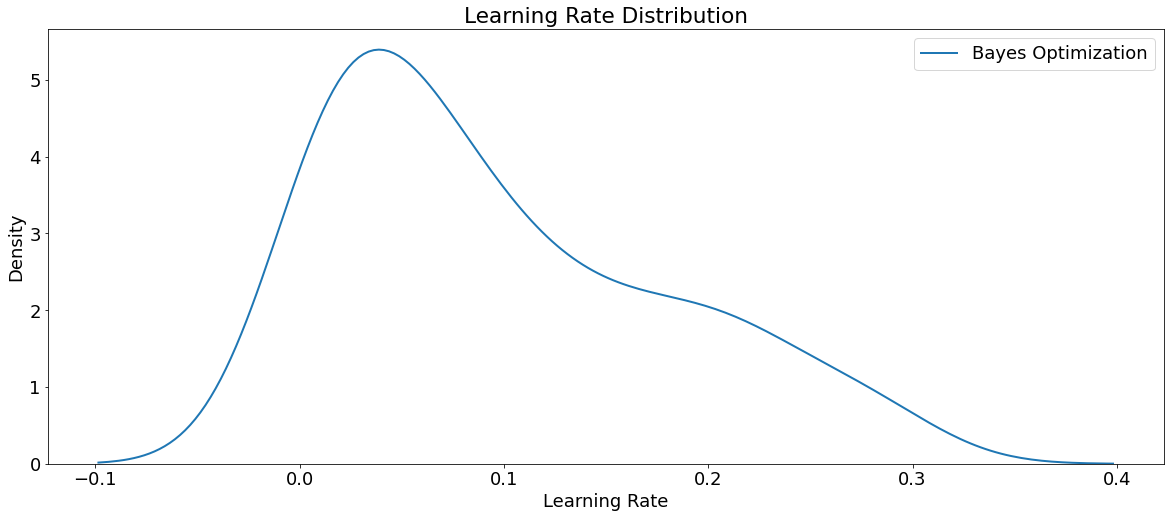

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

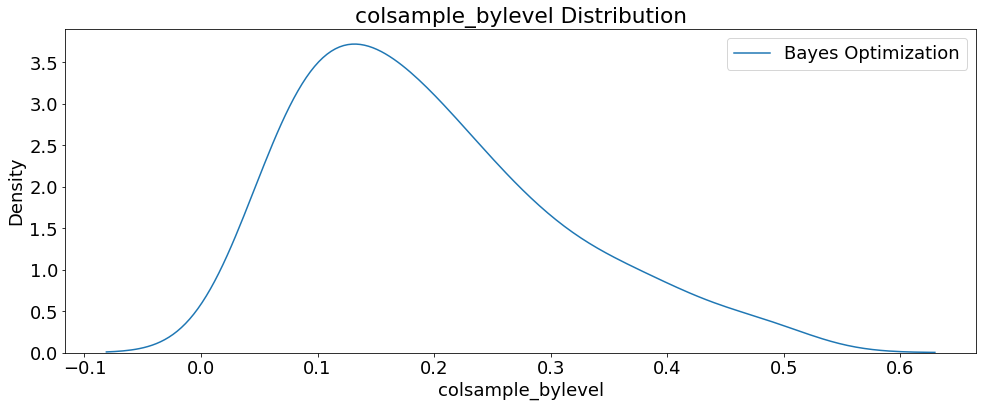

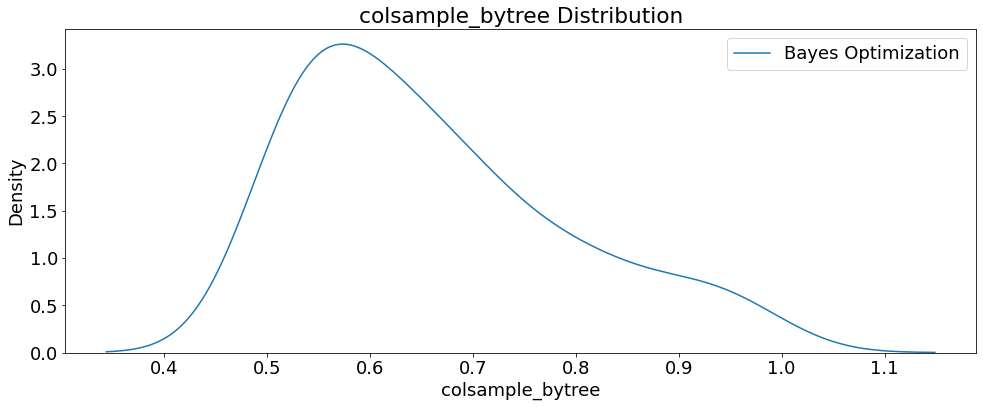

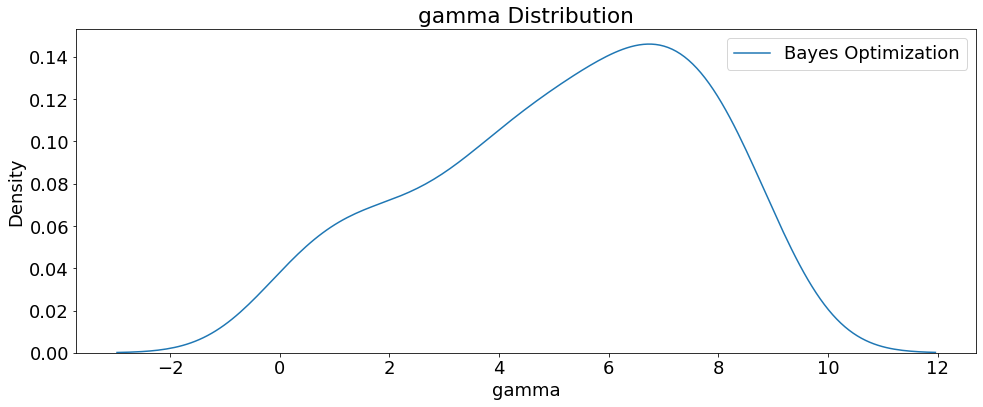

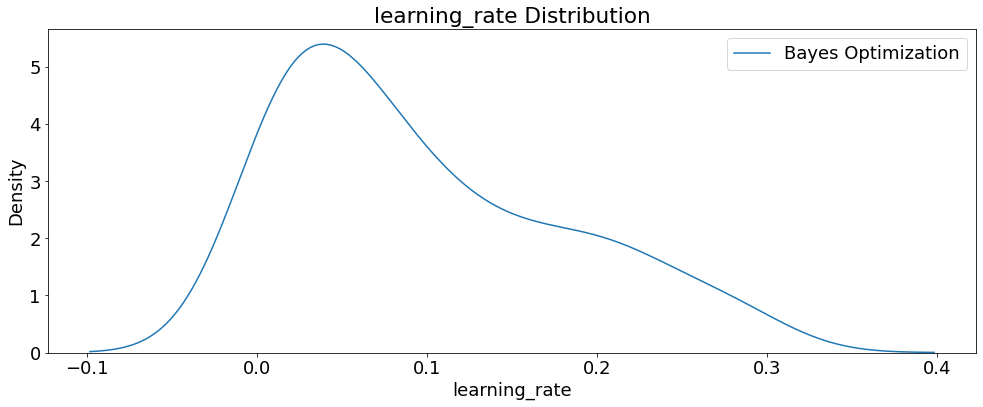

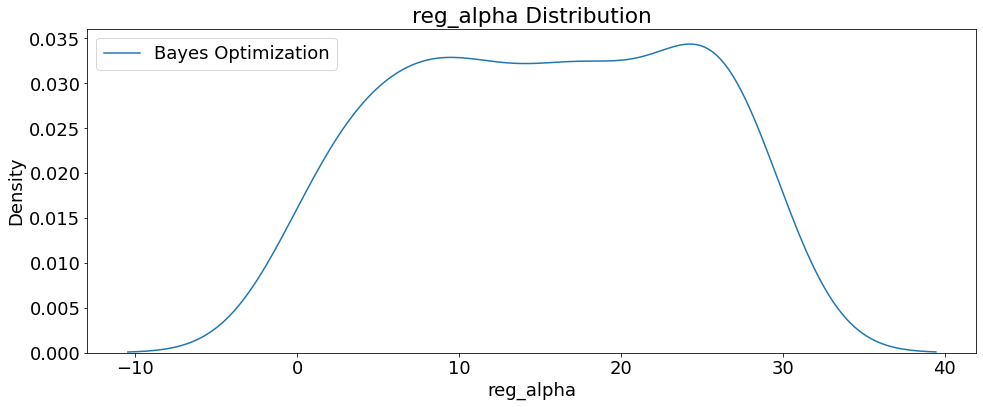

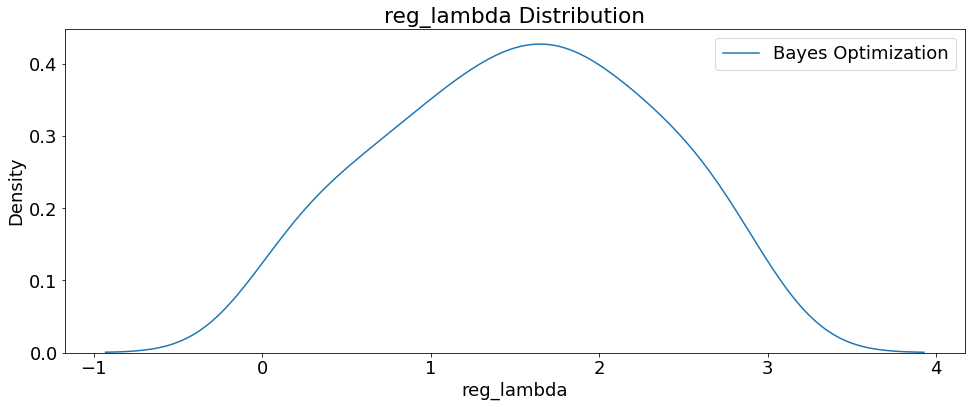

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

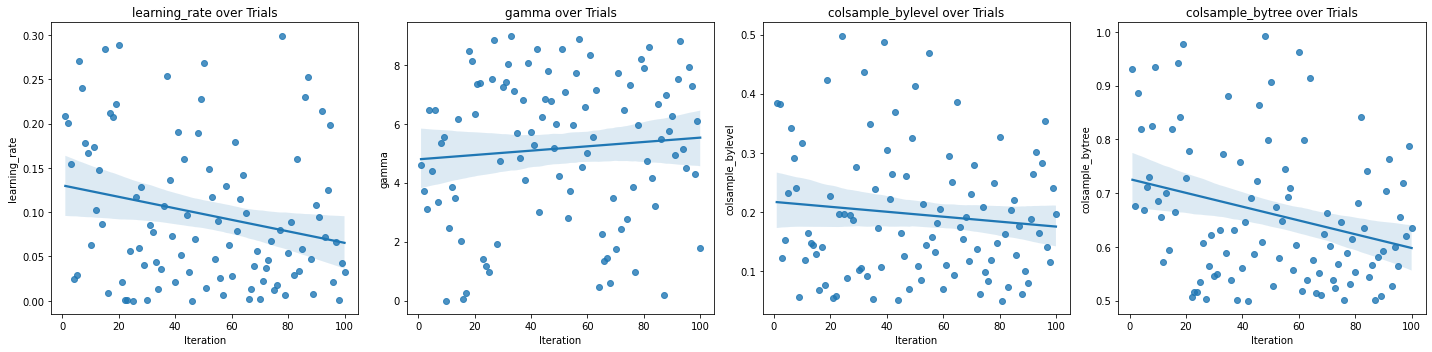

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

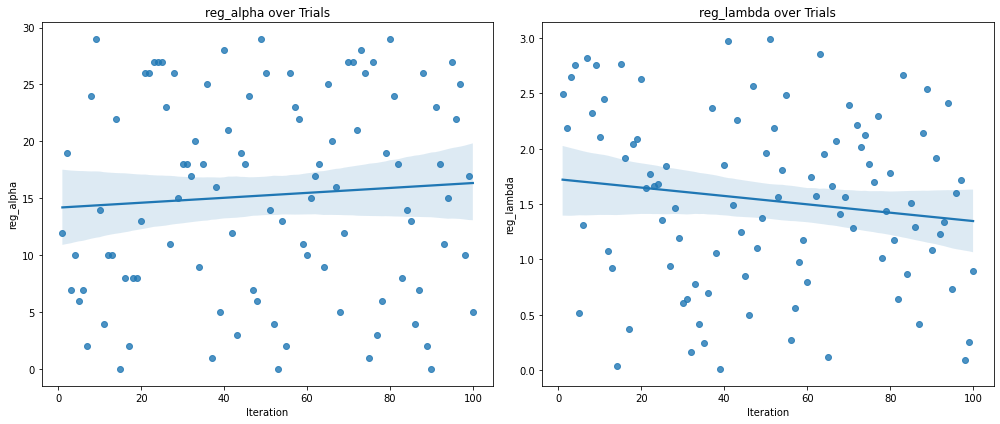

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_5fold_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_100_GPU_5fold_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0731 ± 0.0005,last_pymnt_amnt
0.0701 ± 0.0006,out_prncp
0.0501 ± 0.0004,recoveries
0.0065 ± 0.0002,total_pymnt
0.0021 ± 0.0001,loan_amnt
0.0013 ± 0.0001,total_rec_late_fee
0.0011 ± 0.0001,installment
0.0007 ± 0.0002,num_bc_tl
0.0003 ± 0.0001,application_type_Joint App
0.0002 ± 0.0001,delinq_2yrs


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_100_GPU_5fold_WeightsExplain.csv', 
           index=False)
exp

,feature,weight,std
0,last_pymnt_amnt,0.073134,0.000261
1,out_prncp,0.070059,0.000300
2,recoveries,0.050104,0.000184
3,total_pymnt,0.006501,0.000104
4,loan_amnt,0.002132,0.000069
5,total_rec_late_fee,0.001299,0.000047
6,installment,0.001053,0.000073
7,num_bc_tl,0.000723,0.000082
8,application_type_Joint App,0.000298,0.000042
9,delinq_2yrs,0.000198,0.000056


## 300 Trials 3-Fold Cross Validation 

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# File to save first results
out_file = 'XGB_HPO_Upsampling_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-05 22:40:57.327637
100%|██████████| 300/300 [7:50:12<00:00, 94.04s/it, best loss: 1.9178987015514055]
Start Time           2022-02-05 22:40:57.327637
End Time             2022-02-06 06:31:09.951497
7:50:12


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9178987015514055, 'params': {'colsample_bylevel': 0.0715989850431816, 'colsample_bytree': 0.5105662734686565, 'gamma': 8.12303987906343, 'learning_rate': 0.0036724758701127303, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 123, 'reg_alpha': 2, 'reg_lambda': 0.39148685566723485, 'subsample': 0.7120835975069001}, 'iteration': 292, 'train_time': 39.6940840319985, 'status': 'ok'}, {'loss': 1.927202732311983, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 89.61974457800034, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value,
                                            verbosity=0,
                                            **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_Upsampling_HPO_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_Upsampling_HPO_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Upsampling 300trials GPU')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Xgboost HPO Upsampling 300trials GPU
Results from Xgboost HPO 300 GPU on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92    377848
           1       0.47      0.82      0.60     54625

    accuracy                           0.86    432473
   macro avg       0.72      0.84      0.76    432473
weighted avg       0.91      0.86      0.88    432473



Confusion matrix:
[[327626  50222]
 [  9695  44930]]


Accuracy score : 0.861
Precision score : 0.472
Recall score : 0.823
F1 score : 0.600


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                     preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 300 GPU trials optimization scores 0.91969 AUC ROC on the test set.
This was achieved after 292 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_300_GPU.csv', index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

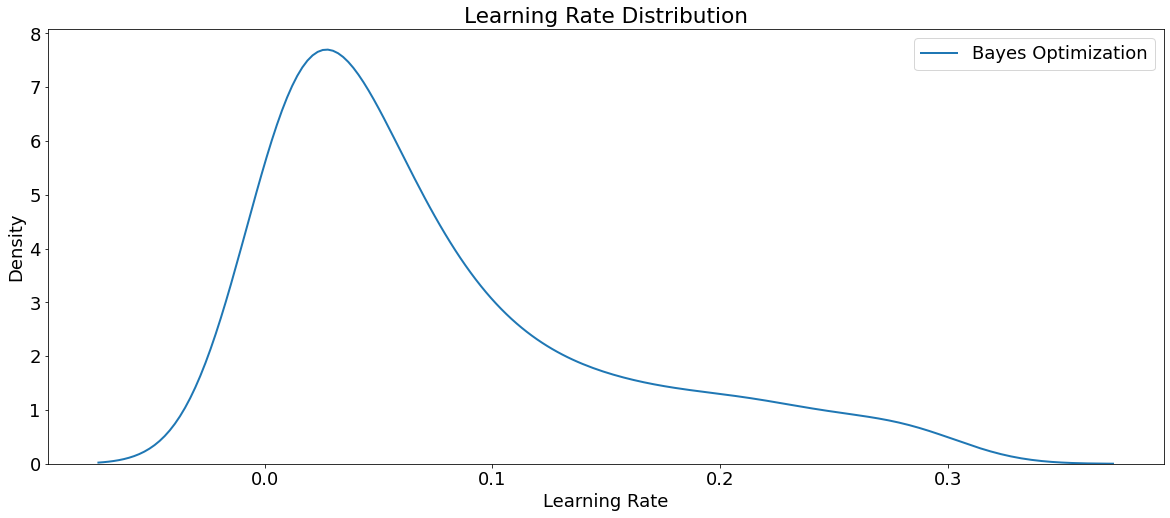

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

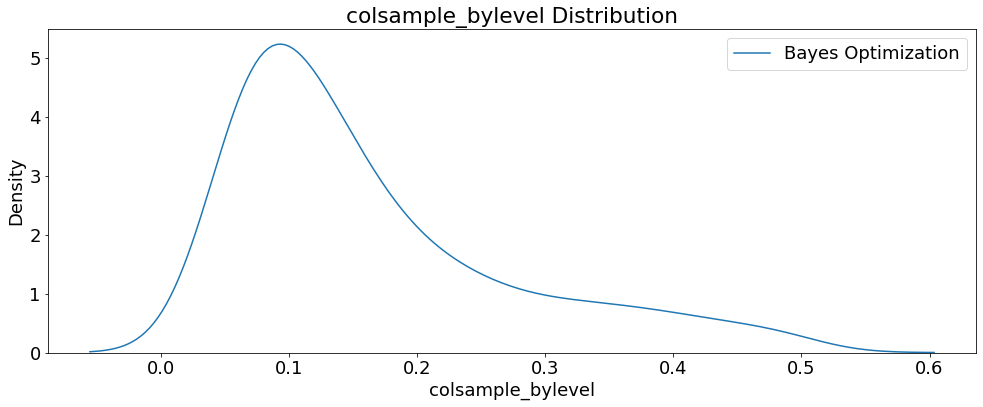

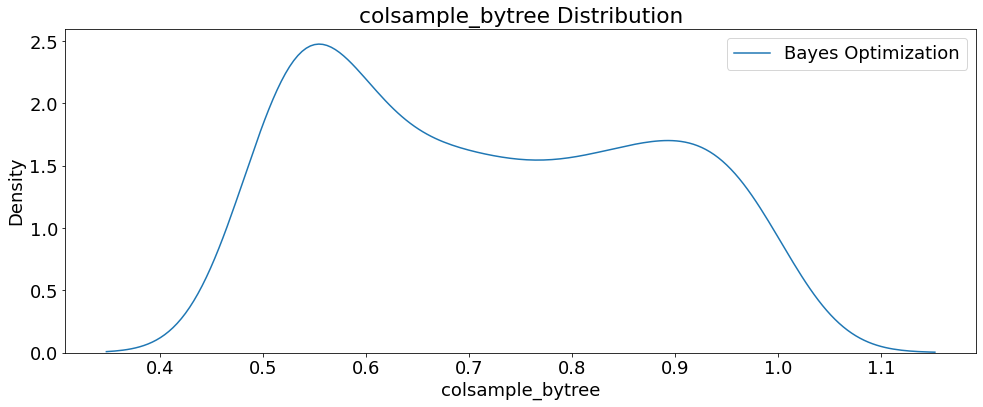

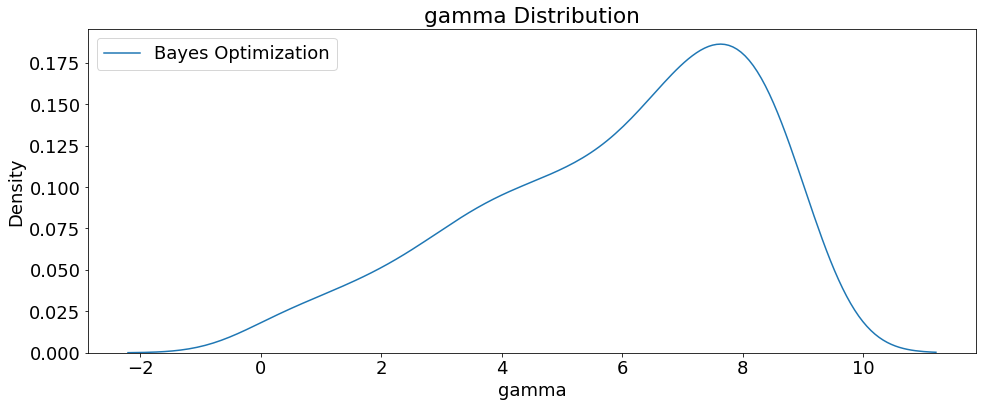

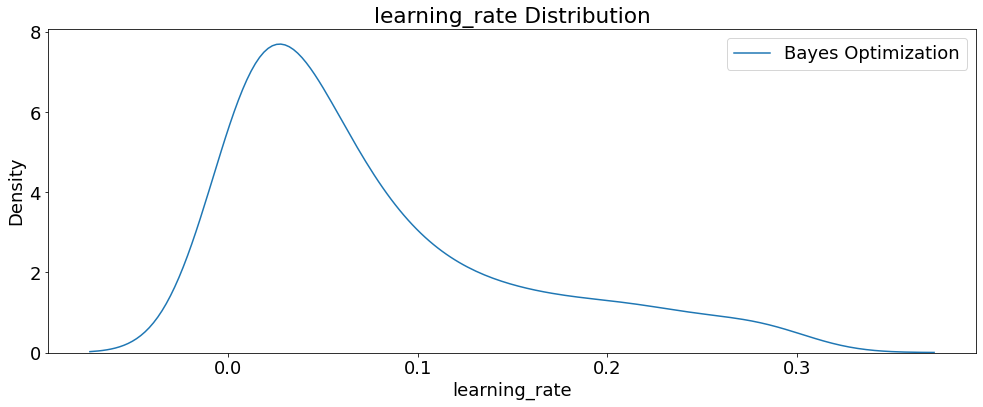

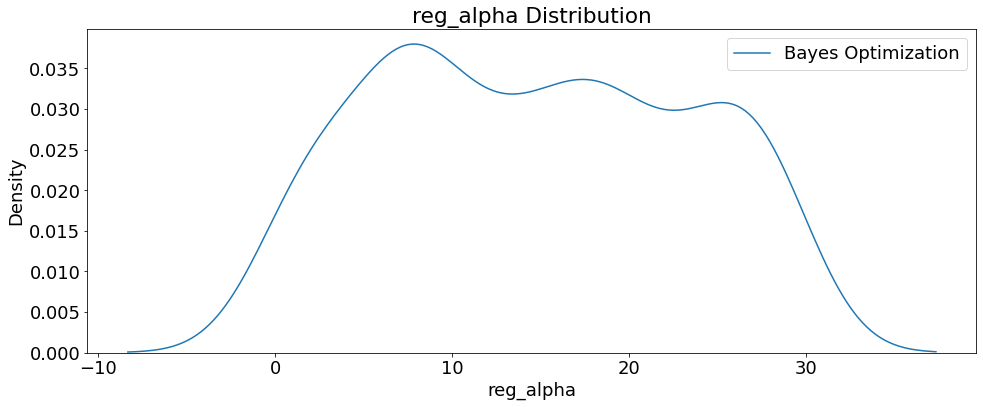

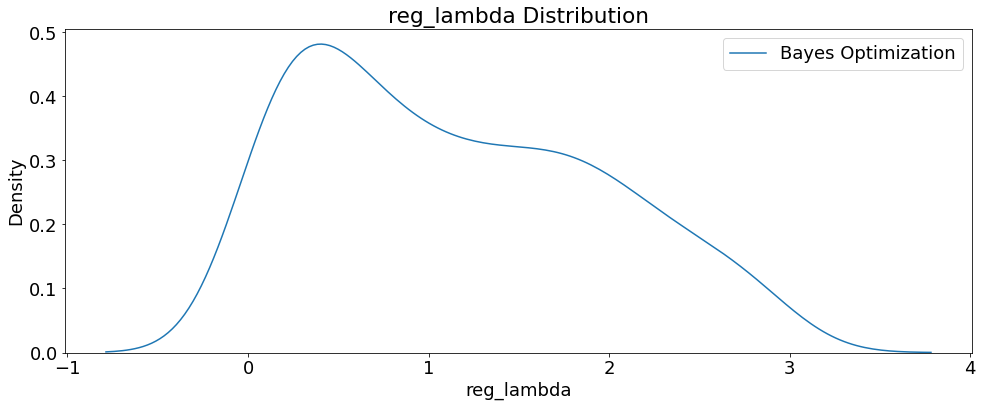

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

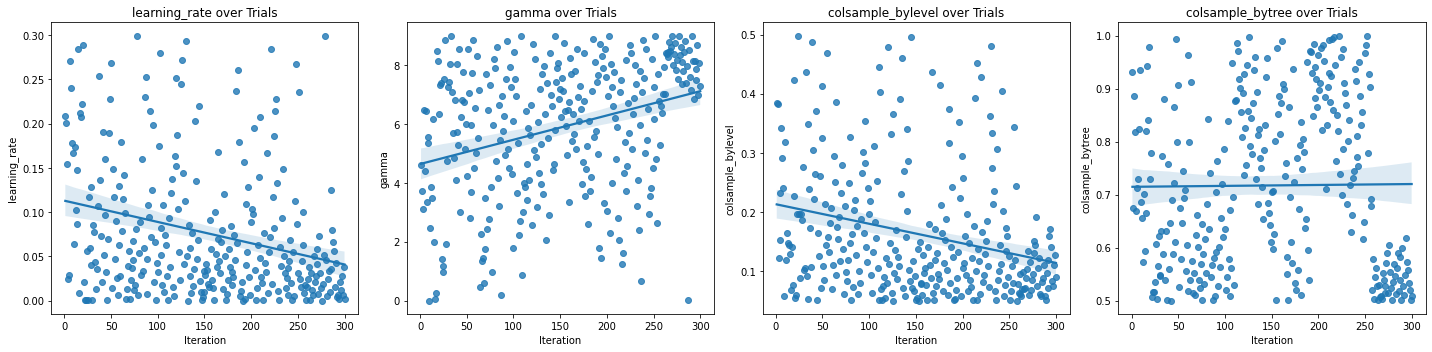

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

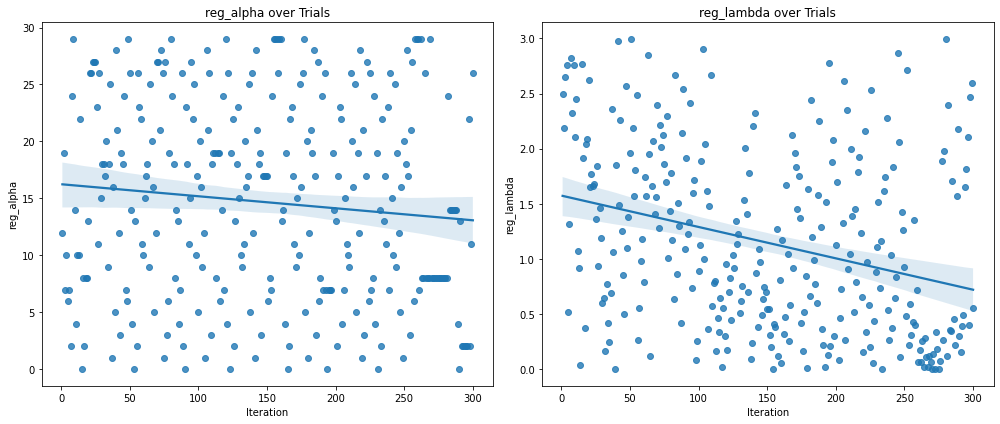

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0436 ± 0.0004,recoveries
0.0436 ± 0.0006,out_prncp
0.0378 ± 0.0005,last_pymnt_amnt
0.0268 ± 0.0002,total_pymnt
0.0103 ± 0.0006,loan_amnt
0.0035 ± 0.0002,total_rec_late_fee
0.0007 ± 0.0002,application_type_Joint App
0.0006 ± 0.0001,installment
0.0006 ± 0.0001,num_bc_sats
0.0004 ± 0.0001,num_bc_tl


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_300_GPU_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,recoveries,0.043608,0.000182
1,out_prncp,0.043593,0.000290
2,last_pymnt_amnt,0.037755,0.000259
3,total_pymnt,0.026765,0.000109
4,loan_amnt,0.010268,0.000311
5,total_rec_late_fee,0.003506,0.000104
6,application_type_Joint App,0.000662,0.000078
7,installment,0.000635,0.000033
8,num_bc_sats,0.000614,0.000075
9,num_bc_tl,0.000438,0.000045


## 300 Trials 3-Fold Cross Validation with More Estimators

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# Define parameter grid
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

# File to save first results
out_file = 'XGB_HPO_Upsampling_300Estimators_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-06 15:09:40.966981
100%|██████████| 300/300 [14:17:08<00:00, 171.43s/it, best loss: 1.9391269970945937]
Start Time           2022-02-06 15:09:40.966981
End Time             2022-02-07 05:26:49.489366
14:17:08


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key=lambda x: x['loss'])
print('Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9391269970945937, 'params': {'colsample_bylevel': 0.05915941293280249, 'colsample_bytree': 0.5396772003839011, 'gamma': 5.036103214846245, 'learning_rate': 0.00010516255251279843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 374, 'reg_alpha': 2, 'reg_lambda': 0.2388993258830624, 'subsample': 0.46058729861450615}, 'iteration': 148, 'train_time': 109.34018602599826, 'status': 'ok'}, {'loss': 1.9419462159941352, 'params': {'colsample_bylevel': 0.05818193624615418, 'colsample_bytree': 0.5581370786859708, 'gamma': 8.857493192485812, 'learning_rate': 0.0005461788653940375, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 162, 'reg_alpha': 4, 'reg_lambda': 0.5682999882661558, 'subsample': 0.2601512415192845}, 'iteration': 274, 'train_time': 59.163153970002895, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_Upsampling_300Estimators_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = XGBClassifier(objective='binary:logistic',
                                            booster='gbtree',
                                            tree_method='gpu_hist', 
                                            scale_pos_weight=1,
                                            use_label_encoder=False,
                                            random_state=seed_value, 
                                            verbosity=0,
                                            **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_Upsampling_HPO_300Estimators_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_Upsampling_HPO_300Estimators_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Upsampling 300trials Estimators GPU')
# Predict based on training 
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for XGBoost HPO Upsampling 300trials Estimators GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    377848
           1       0.54      0.85      0.66     54625

    accuracy                           0.89    432473
   macro avg       0.76      0.87      0.80    432473
weighted avg       0.92      0.89      0.90    432473



Confusion matrix:
[[337898  39950]
 [  8066  46559]]


Accuracy score : 0.889
Precision score : 0.538
Recall score : 0.852
F1 score : 0.660


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 300 Estimators GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, 
                                                                                                                                                preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 300 Estimators GPU trials optimization scores 0.94063 AUC ROC on the test set.
This was achieved after 148 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_HPO_Upsampling_300_Estimators_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

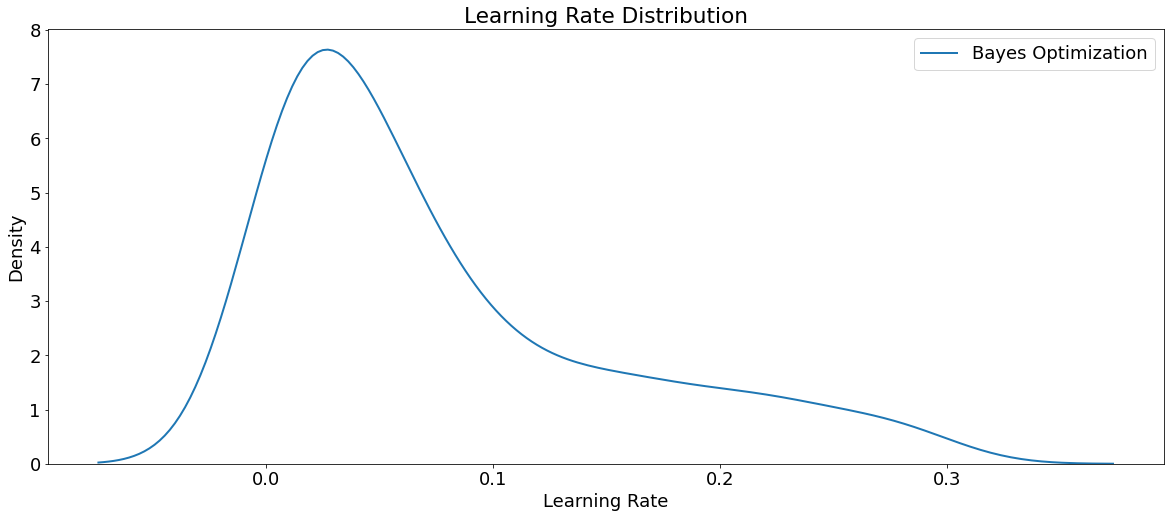

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

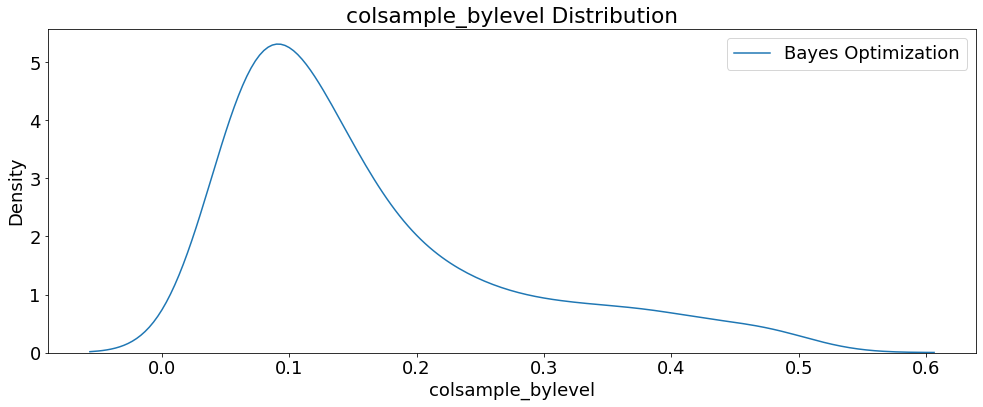

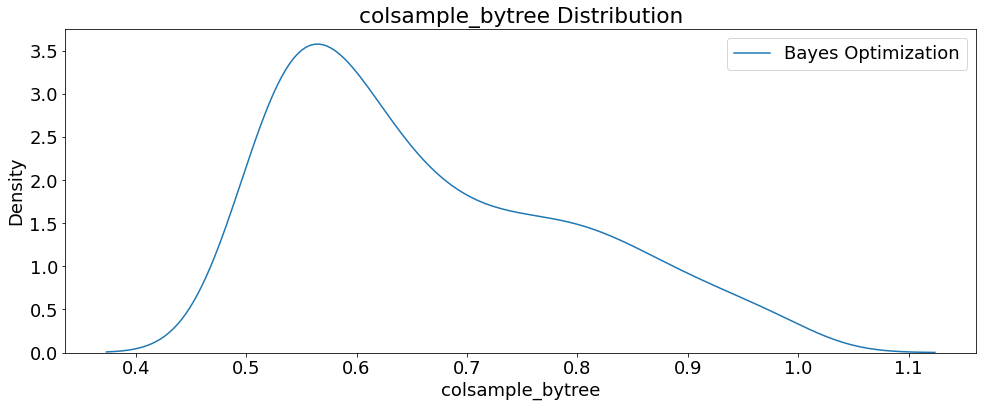

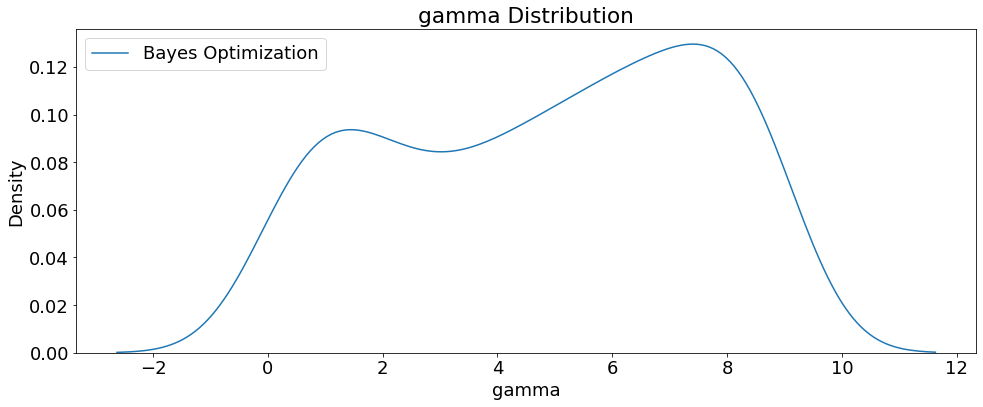

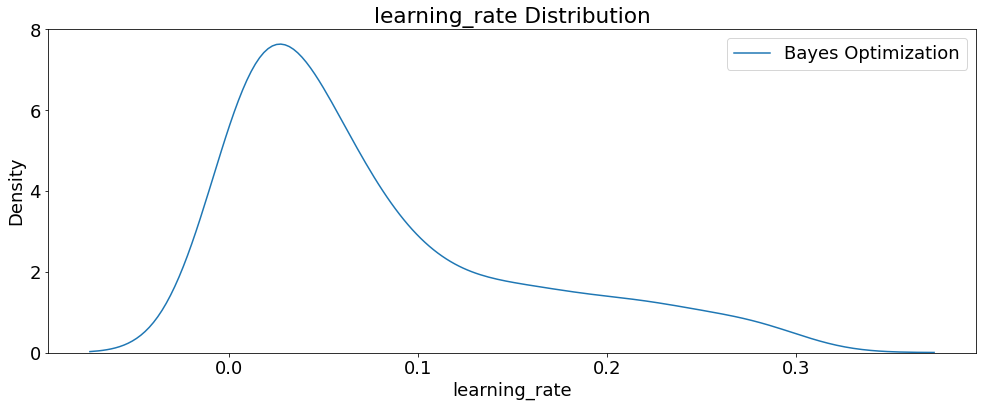

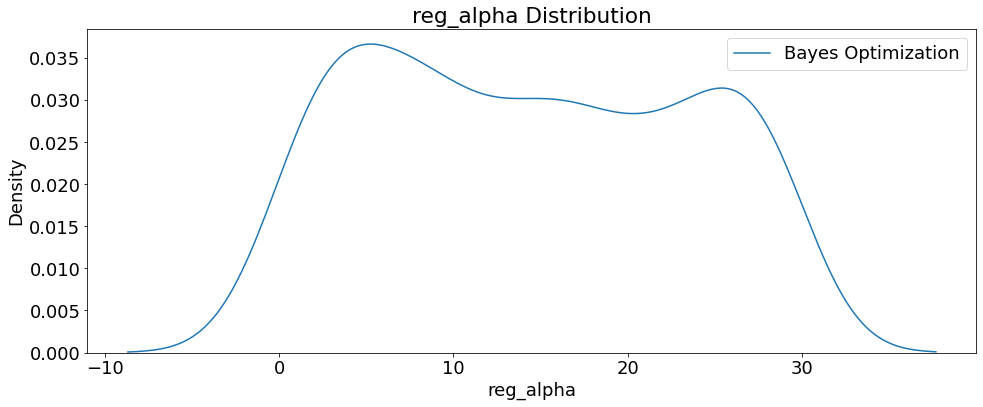

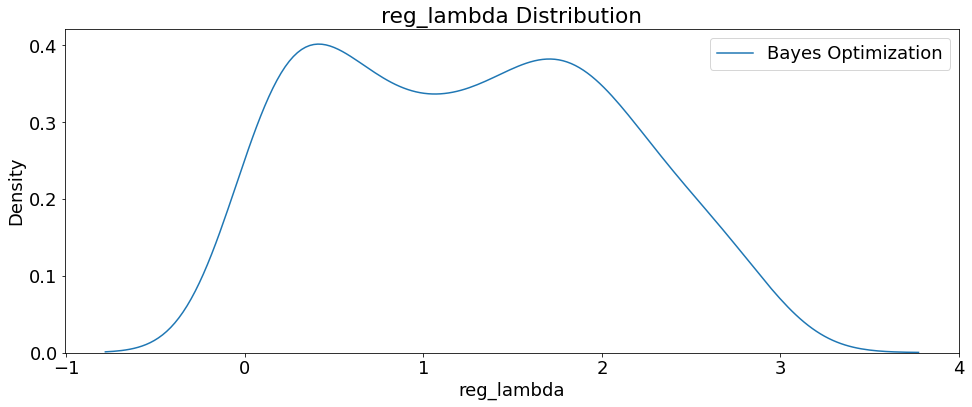

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

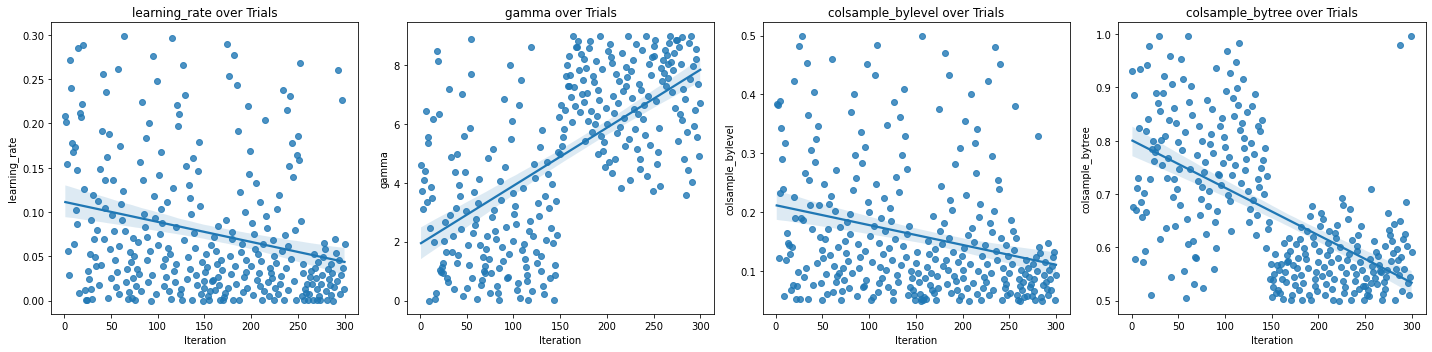

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

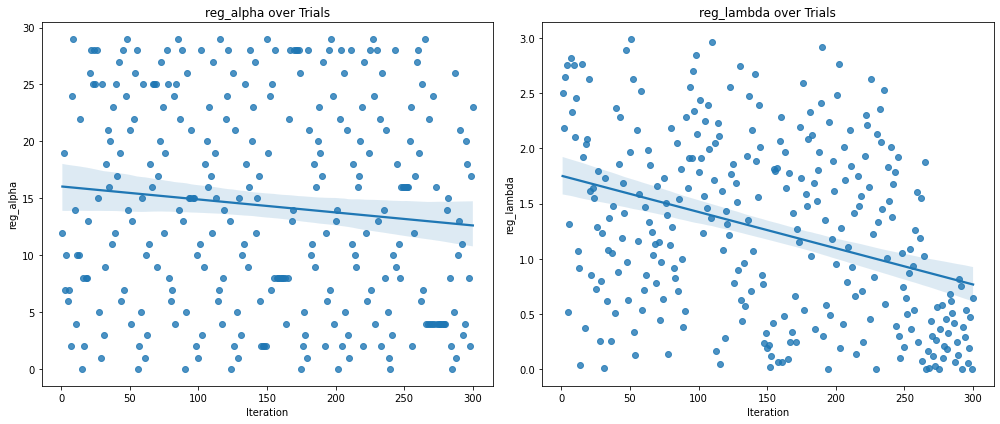

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_300_Estimators_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/XGBoost/Hyperopt/TrainTest/Model_Explanations/best_bayes_Upsampling_300_Estimators_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0802 ± 0.0004,out_prncp
0.0781 ± 0.0006,last_pymnt_amnt
0.0335 ± 0.0005,recoveries
0.0151 ± 0.0003,total_pymnt
0.0035 ± 0.0002,total_rec_late_fee
0.0025 ± 0.0001,loan_amnt
0.0016 ± 0.0002,term_ 60 months
0.0010 ± 0.0002,installment
0.0006 ± 0.0001,num_bc_tl
0.0004 ± 0.0000,application_type_Joint App


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_300_Estimators_GPU_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,out_prncp,0.080177,0.000200
1,last_pymnt_amnt,0.078140,0.000300
2,recoveries,0.033542,0.000271
3,total_pymnt,0.015130,0.000143
4,total_rec_late_fee,0.003471,0.000115
5,loan_amnt,0.002473,0.000040
6,term_ 60 months,0.001602,0.000097
7,installment,0.000976,0.000103
8,num_bc_tl,0.000597,0.000057
9,application_type_Joint App,0.000378,0.000013
